# Topographic VAE tutorial

In [4]:
from tvae.models import BernoulliTopoVAE
from tvae.utils import lateral_effect, mexican_hat

import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set seed
SEED = 2022
torch.manual_seed(SEED);

N dimensional dataset of gaussian noise for training

In [5]:
# Hyperparameters
INPUT_SIZE = 9
N_SAMPLES = 10000

# Dataset of N dimensional gaussian noise
data = torch.randn(size=(N_SAMPLES, INPUT_SIZE))

# Move to GPU (remove this line if not using GPU for training)
data = data.cuda()

Initialise model

In [6]:
# Hyperparameters
LATENT_SHAPE = [20,20] # Dimensions of 2D latent space 
LATENT_DIM = LATENT_SHAPE[0] * LATENT_SHAPE[1] # No. of neurons in 2D latent space
SIGMA = 2 # Controls range of lateral effects
N = 5 # Maximum allowed spike range of each neuron for a single input

# Initialise Psi, which defines the desired pairwise interactions between neurons
psi = lateral_effect(LATENT_SHAPE, SIGMA, mexican_hat)
psi = torch.tensor(psi).float()

# Initialise model
model = BernoulliTopoVAE(INPUT_SIZE, LATENT_DIM, psi, n=N, device='cpu')

# Move model compoinents to GPU (remove these lines if not using GPU for training)
model.device = 'cuda:0'
model.psi = model.psi.cuda()
model.cuda()

BernoulliTopoVAE(
  (encoder): Sequential(
    (0): Linear(in_features=9, out_features=500, bias=False)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=400, bias=False)
    (3): Sigmoid()
  )
  (decoder): Linear(in_features=400, out_features=9, bias=False)
)

Train model

In [7]:
# Wrap data in dataloader object
dataloader = DataLoader(data, batch_size=256, drop_last=True, shuffle=True) 

In [8]:
# Training hyperparameters
N_EPOCHS = 500
lateral_weight = 1
KL_weight = 0

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

losses = {'total':[], 'reconstruction':[], 'lateral':[]}

for epoch in range(N_EPOCHS):

    total_losses, recon_losses, lateral_losses = [], [], []

    for i_batch, x in enumerate(dataloader):

        optimizer.zero_grad()

        xhat, z, pi, p, inp = model.forward(x)

        reconstruction_loss = loss_fn(x.cpu(), xhat.cpu())
        lateral_loss = model.lateral_loss(p)
        KL_loss = model.KL_divergence(pi)

        loss = reconstruction_loss + lateral_weight * lateral_loss + KL_weight * KL_loss
        loss.backward()

        optimizer.step()

        total_losses.append(loss.detach().item())
        recon_losses.append(reconstruction_loss.detach().item())
        lateral_losses.append(lateral_loss.detach().item())
    
    losses['total'].append(np.mean(total_losses))
    losses['reconstruction'].append(np.mean(recon_losses))
    losses['lateral'].append(np.mean(lateral_losses))

    if (epoch+1) % 25 == 0:
        print(f'Epoch {epoch+1}/{N_EPOCHS} | Loss : {np.mean(total_losses)}')



Epoch 25/500 | Loss : 0.029559338656373512
Epoch 50/500 | Loss : 0.024987132551196296
Epoch 75/500 | Loss : 0.023745638342239916
Epoch 100/500 | Loss : 0.02180218338393248
Epoch 125/500 | Loss : 0.02137639034443941
Epoch 150/500 | Loss : 0.020237283303569525
Epoch 175/500 | Loss : 0.019859333594258014
Epoch 200/500 | Loss : 0.020007187739396706
Epoch 225/500 | Loss : 0.01931141756283931
Epoch 250/500 | Loss : 0.01949608091933605
Epoch 275/500 | Loss : 0.01944469555448263
Epoch 300/500 | Loss : 0.019288976366321247
Epoch 325/500 | Loss : 0.01880356779274268
Epoch 350/500 | Loss : 0.018542746129708413
Epoch 375/500 | Loss : 0.01863802243501712
Epoch 400/500 | Loss : 0.01854925796103019
Epoch 425/500 | Loss : 0.019459983811546594
Epoch 450/500 | Loss : 0.018685061627855666
Epoch 475/500 | Loss : 0.018744573068733398
Epoch 500/500 | Loss : 0.01749286884203171


Plot loss curves

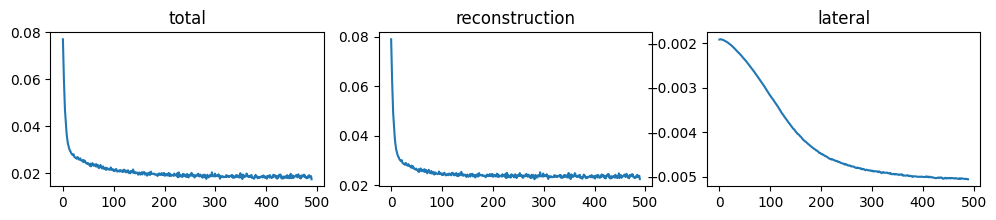

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12,2))

for i, key in enumerate(losses.keys()):
    axs[i].plot(losses[key][10:])
    axs[i].set_title(key)

Move model to CPU

In [10]:
model.eval()

model.cpu()
model.device = 'cpu'
data = data.cpu()
model.psi = model.psi.cpu()

Generate reconstruction and neural activity for the data

In [11]:
# Switch to non-differentiable spike counts samples (gives discrete spikes)
model.round_counts(True)

In [12]:
# Run inference
with torch.no_grad():
    xhat, z, pi, p, x = model.forward(data)

Plot reconstruction quality and activity for random samples

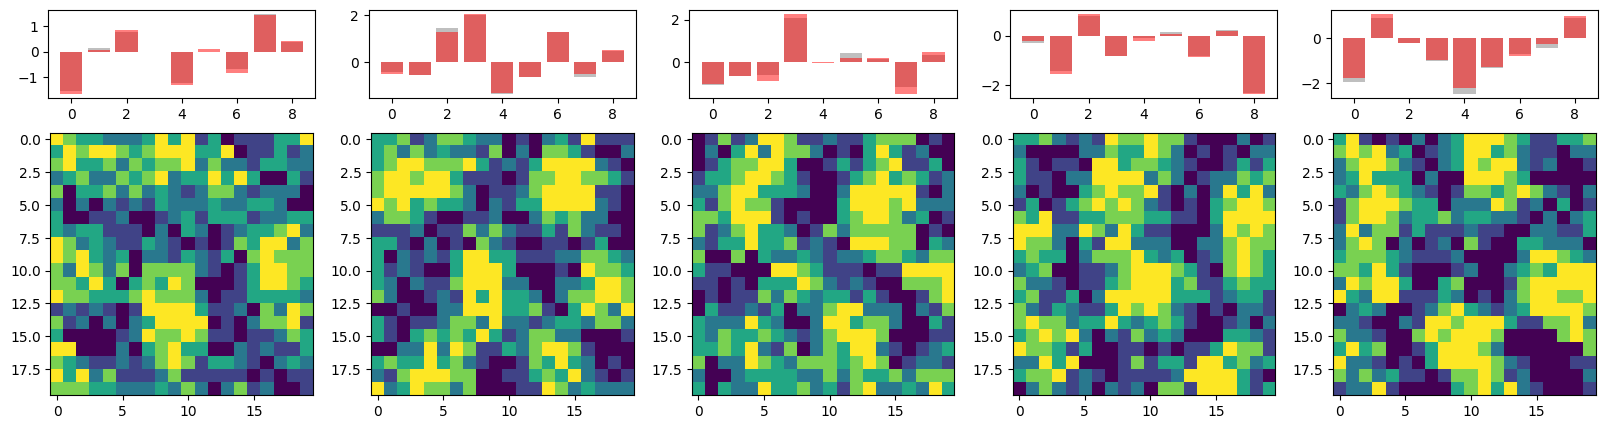

In [13]:
fig,axs = plt.subplots(2,5, figsize=(20,5), gridspec_kw={'height_ratios':[1,3]})

idxs = np.random.choice(10000, 5, replace=False)

for i, idx in enumerate(idxs):
    axs[0,i].bar(range(9), data[idx,:], color='gray', alpha=0.5)
    axs[0,i].bar(range(9), xhat[idx,:], color='red', alpha=0.5)

for i, idx in enumerate(idxs):
    axs[1,i].imshow(z[idx,:].reshape(*LATENT_SHAPE))